<a href="https://colab.research.google.com/github/starling-lab/PDGM-Workshop-IITM-2024/blob/main/PDGM_IITM_Day2_TensorPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# Workshop on Probabilistic Deep Generative Models

---


In this notebook, we will look at how to train a Deep Probabilistic Circuit - an **Einsum Network** [1] to model the joint probability distribution over handwritten digits. We will also look at how we can use tractability of probabilistic inference to perform inpainting when pixels are occluded.


[1] *R. Peharz, S. Lang, A. Vergari, K. Stelzner, A. Molina, M. Trapp, G. Van den Broeck, K. Kersting, Z. Ghahramani, Einsum Networks: Fast and Scalable Learning of Tractable Probabilistic Circuits, ICML 2020.*

## Generative Modeling with Einsum Networks

In [ ]:
# Import necessary packages
import os
import numpy as np
import torch, torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

Clone the github repository and install dependencies

In [ ]:
! git clone https://github.com/cambridge-mlg/EinsumNetworks
%cd EinsumNetworks/
%cd src

fatal: destination path 'EinsumNetworks' already exists and is not an empty directory.
/content/EinsumNetworks
/content/EinsumNetworks/src


In [ ]:
## Uncomment and run if you find networkx related errors/warnings
# !pip3 install --upgrade --force-reinstall networkx==2.4.0

### Initializing an Einsum Network for the MNIST dataset

In [ ]:
import datasets
import utils
# 'EinsumNetwork' is the main class for creating and training the Einsum Network.
from EinsumNetwork import Graph, EinsumNetwork

# use gpu to run computations, if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Set the hyperparameters corresponding to the MNIST dataset

In [ ]:
classes = [1,2,3] # List of classes to model. We will model the digits 1,2 and 3
width   = 28
height  = 28

Set the hyperparameters to specify the EinsumNet structure


In [ ]:
depth = 4
num_repetitions = 20 # The number of replicas/ensemble components to be evaluated in parallel
K = 10 # The number of vectorized sum and leaf distributions
exponential_family = EinsumNetwork.BinomialArray # Leaf distribution

# We will use the poon and domingos structure which invloves randomly splitting variables arranged in a grid along axis aligned cuts, suitable for image data
structure = 'poon-domingos'
pd_num_pieces = [4]

# Leaf distribution hyperparameters. Each pixel can take 256 values (0-255) when using a discrete distribution at the leaves
exponential_family_args = None
if exponential_family == EinsumNetwork.BinomialArray:
    exponential_family_args = {'N': 256}
if exponential_family == EinsumNetwork.CategoricalArray:
    exponential_family_args = {'K': 256}
if exponential_family == EinsumNetwork.NormalArray:
    exponential_family_args = {'min_var': 1e-6, 'max_var': 0.1}

Set the training hyperparameters

In [ ]:
# We will use EM to train the model
num_epochs = 5
batch_size = 100
online_em_frequency = 1
online_em_stepsize = 0.05


Load the dataset and normalize if using a continuous leaf distribution

In [ ]:
# get data
train_x, train_labels, test_x, test_labels = datasets.load_mnist()

if not exponential_family != EinsumNetwork.NormalArray:
    train_x /= 255.
    test_x /= 255.
    train_x -= .5
    test_x -= .5

# validation split
valid_x = train_x[-10000:, :]
train_x = train_x[:-10000, :]
valid_labels = train_labels[-10000:]
train_labels = train_labels[:-10000]

# pick the selected classes
if classes is not None:
    train_x = train_x[np.any(np.stack([train_labels == c for c in classes], 1), 1), :]
    valid_x = valid_x[np.any(np.stack([valid_labels == c for c in classes], 1), 1), :]
    test_x = test_x[np.any(np.stack([test_labels == c for c in classes], 1), 1), :]

train_x = torch.from_numpy(train_x).to(torch.device(device))
valid_x = torch.from_numpy(valid_x).to(torch.device(device))
test_x = torch.from_numpy(test_x).to(torch.device(device))

9912422 Bytes
Move to ../data/mnist/train-images-idx3-ubyte.gz
unzip ../data/mnist/train-images-idx3-ubyte.gz
28881 Bytes
Move to ../data/mnist/train-labels-idx1-ubyte.gz
unzip ../data/mnist/train-labels-idx1-ubyte.gz
1648877 Bytes
Move to ../data/mnist/t10k-images-idx3-ubyte.gz
unzip ../data/mnist/t10k-images-idx3-ubyte.gz
4542 Bytes
Move to ../data/mnist/t10k-labels-idx1-ubyte.gz
unzip ../data/mnist/t10k-labels-idx1-ubyte.gz


Build the EinsumNetwork

In [ ]:
if structure == 'poon-domingos':
    pd_delta = [[height / d, width / d] for d in pd_num_pieces]
    graph = Graph.poon_domingos_structure(shape=(height, width), delta=pd_delta)
elif structure == 'binary-trees':
    graph = Graph.random_binary_trees(num_var=train_x.shape[1], depth=depth, num_repetitions=num_repetitions)
else:
    raise AssertionError("Unknown Structure")

args = EinsumNetwork.Args(
        num_var=train_x.shape[1],
        num_dims=1,
        num_classes=10,
        num_sums=K,
        num_input_distributions=K,
        exponential_family=exponential_family,
        exponential_family_args=exponential_family_args,
        online_em_frequency=online_em_frequency,
        online_em_stepsize=online_em_stepsize)

einet = EinsumNetwork.EinsumNetwork(graph, args)
einet.initialize()
einet.to(device)
print(einet)

EinsumNetwork(
  (einet_layers): ModuleList(
    (0): FactorizedLeafLayer(
      (ef_array): BinomialArray()
    )
    (1-2): 2 x EinsumLayer()
    (3): EinsumMixingLayer()
    (4): EinsumLayer()
    (5): EinsumMixingLayer()
    (6): EinsumLayer()
    (7): EinsumMixingLayer()
    (8): EinsumLayer()
    (9): EinsumMixingLayer()
    (10): EinsumLayer()
    (11): EinsumMixingLayer()
  )
)


## Train the model using Maximum Likelihood

In [ ]:
# Train
train_N = train_x.shape[0]
valid_N = valid_x.shape[0]
test_N = test_x.shape[0]

for epoch_count in range(num_epochs):
    ##### evaluate
    einet.eval()
    train_ll = EinsumNetwork.eval_loglikelihood_batched(einet, train_x, batch_size=batch_size)
    valid_ll = EinsumNetwork.eval_loglikelihood_batched(einet, valid_x, batch_size=batch_size)
    test_ll = EinsumNetwork.eval_loglikelihood_batched(einet, test_x, batch_size=batch_size)
    print("[{}]   train LL {}   valid LL {}   test LL {}".format(
        epoch_count,
        train_ll / train_N,
        valid_ll / valid_N,
        test_ll / test_N))
    #####
    einet.train()
    idx_batches = torch.randperm(train_N, device=device).split(batch_size)
    total_ll = 0.0
    for idx in tqdm(idx_batches):
        batch_x = train_x[idx, :]
        outputs = einet.forward(batch_x)
        ll_sample = EinsumNetwork.log_likelihoods(outputs)
        log_likelihood = ll_sample.sum()
        log_likelihood.backward()
        einet.em_process_batch()
        total_ll += log_likelihood.detach().item()
    einet.em_update()

[0]   train LL -148267.3275862069   valid LL -148115.12678339818   test LL -148221.33050047213


100%|██████████| 158/158 [00:10<00:00, 14.85it/s]


[1]   train LL -14865.39899266527   valid LL -14723.598978599222   test LL -14630.64923670129


100%|██████████| 158/158 [00:05<00:00, 28.14it/s]


[2]   train LL -14633.957122785292   valid LL -14487.178947795072   test LL -14412.30897859616


100%|██████████| 158/158 [00:04<00:00, 34.59it/s]


[3]   train LL -14569.333611164031   valid LL -14462.944917315175   test LL -14314.254249291786


100%|██████████| 158/158 [00:05<00:00, 28.08it/s]


[4]   train LL -14574.688087413475   valid LL -14436.121311608302   test LL -14331.50019672647


100%|██████████| 158/158 [00:04<00:00, 34.48it/s]


## Sampling
Generate samples from the learned distribution and visualize it to compare  against the real data points.


 Real Data



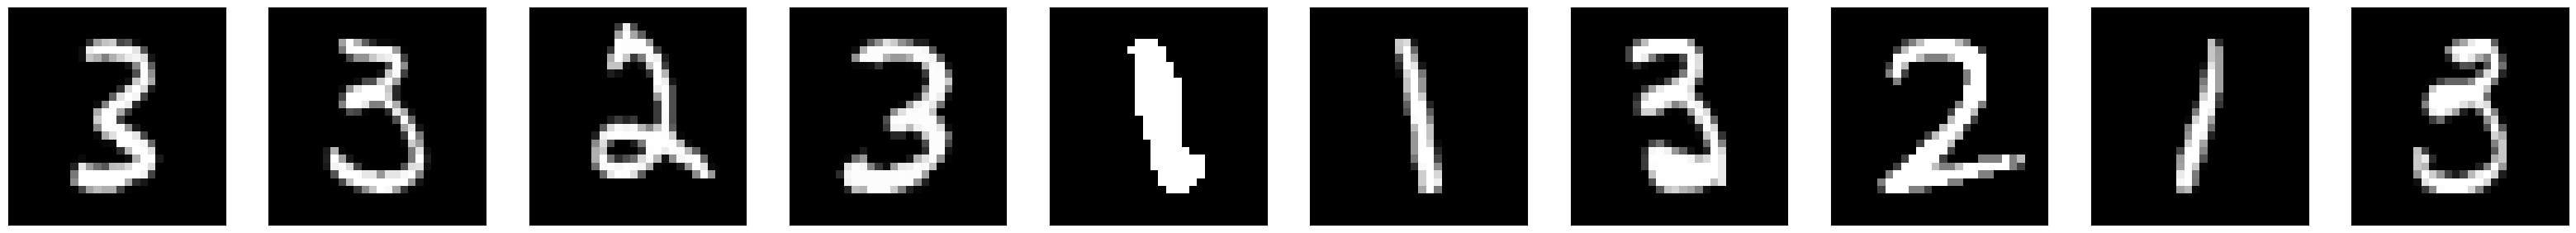


 Generated Data



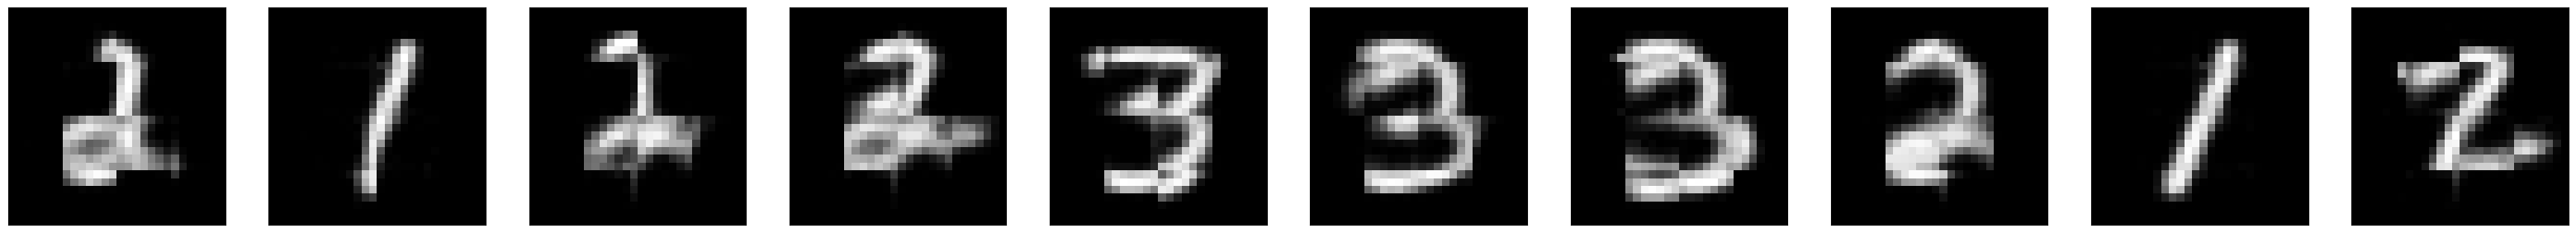

In [ ]:
def plot_mnist(samples):
  n = len(samples)
  fig, axs = plt.subplots(1,n, figsize=(4*n,4))
  for i in range(n):
    axs[i].imshow(samples[i,:,:], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  plt.show()

num_samples = 10
print("\n Real Data\n")
real_samples = valid_x[:num_samples,:].cpu().reshape((-1, 28, 28))
plot_mnist(real_samples)

# draw some samples
print("\n Generated Data\n")
gen_samples = einet.sample(num_samples=num_samples).cpu().numpy()
gen_samples = gen_samples.reshape((-1, 28, 28))
plot_mnist(gen_samples)


### Utilizing Tractablity of Probabilistic Inference

Let us look at how we can use tractability for marginal (MAR) and conditional (CON) queries to handle missing data.

**Let us first corrupt the data by randomly setting pixels to zero.**


 Corrupted Data



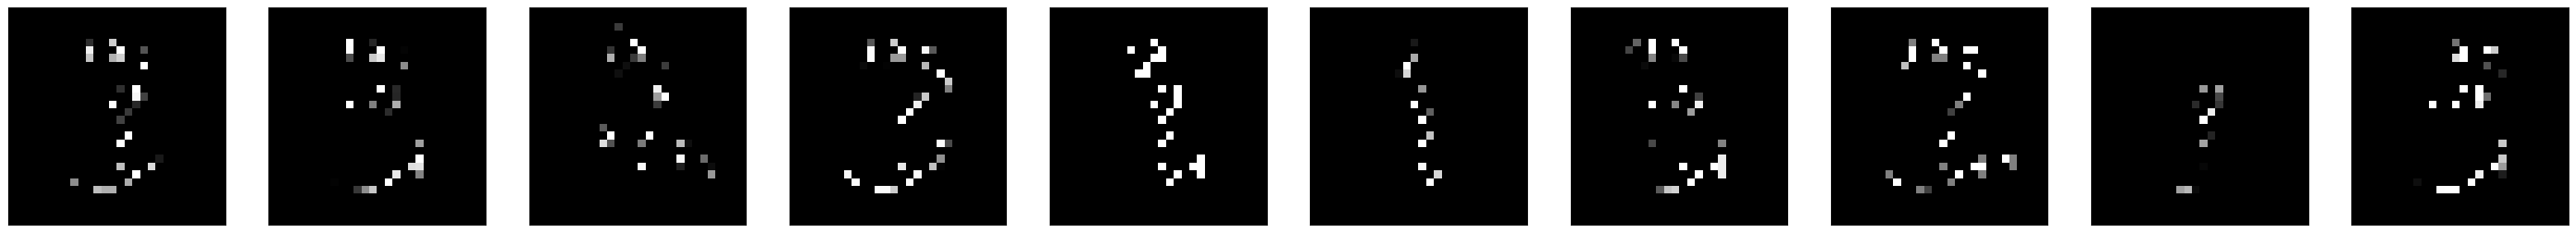

In [ ]:
# Set the num of pixels to corrupt
n_corrupt = 600 # Vary this to play around with the amount of corruption. Max=784
image_scope = np.array(range(height * width)).reshape(height, width)
# Randomly select pixels to corrupt
marginalize_idx = np.random.choice(list(range(784)),n_corrupt, replace=False).reshape(-1)
keep_idx = [i for i in range(width*height) if i not in marginalize_idx]

corrupted_samples = real_samples.clone().view(-1,784)
corrupted_samples[:,marginalize_idx] = 0
print("\n Corrupted Data\n")
plot_mnist(corrupted_samples.reshape(-1, 28, 28))

Now let us **inpaint the corrupted images by sampling from the conditional distribution** over the corrupted pixels given the non corrupted ones.

Inpainted images obtained by sampling from the conditional distribution


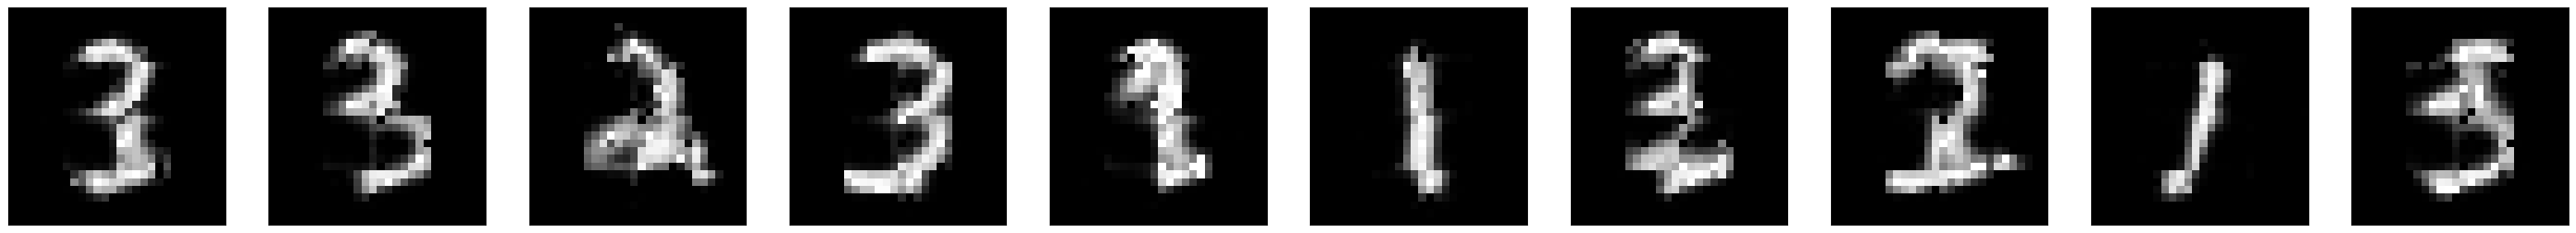

In [ ]:
einet.set_marginalization_idx(marginalize_idx)
num_samples = 10
for k in range(num_samples):
    con_samples = einet.sample(x=corrupted_samples.to(device)).cpu().numpy()
con_samples /= num_samples
con_samples = con_samples.squeeze()
con_samples = con_samples.reshape((-1, 28, 28))
print("Inpainted images obtained by sampling from the conditional distribution")
plot_mnist(con_samples.reshape(-1, 28, 28))


Another way to inpaint the corrupted images is to perform MAP inference over the corrupted pixels. Tractability for MAP requires determinism in addition to smoothness and decomposability. However, einsum networks are not deterministic, hence we cannot do exact MAP inference. We can still approximate MAP by replacing sum nodes by max activations.

Inpainted images obtained by (approximate) MAP inference 


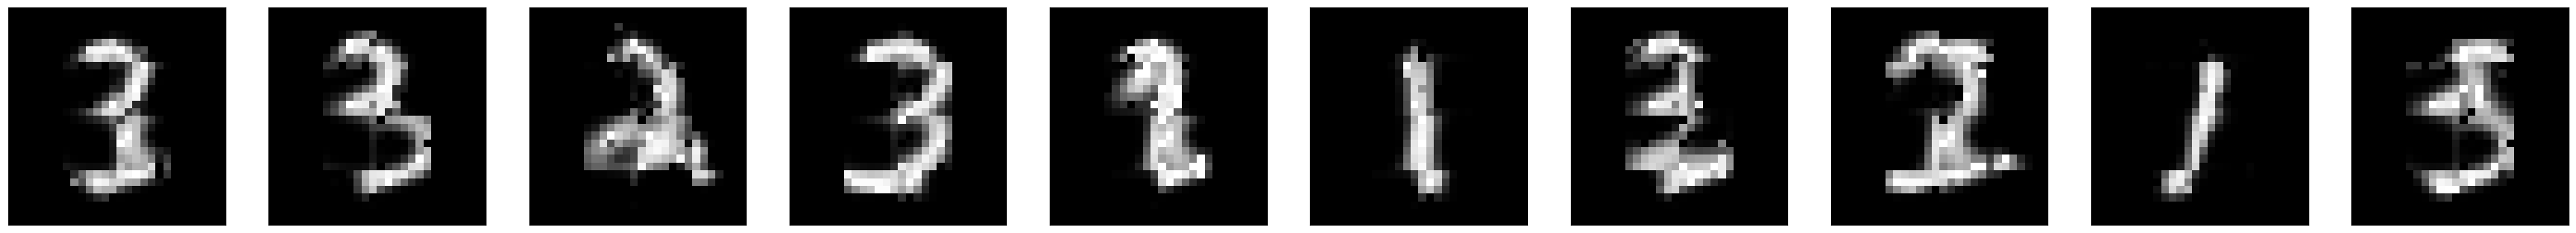

In [ ]:
einet.set_marginalization_idx(marginalize_idx)
mpe_samples = einet.mpe(x=corrupted_samples.to(device)).cpu().numpy()
mpe_samples = mpe_samples.squeeze()
mpe_samples = mpe_samples.reshape((-1, 28, 28))
print("Inpainted images obtained by (approximate) MAP inference ")
plot_mnist(mpe_samples.reshape(-1, 28, 28))